# Set-up

## Select Colab or HPC

In [ ]:
PLATFORM = 'colab' # colab or HPC or laptop

## Import dependencies

In [1]:
import altair as alt
import argparse
import ast
import bz2
from IPython.display import Image
import json
import jsonschema
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import re
import time
import urllib

In [ ]:
if PLATFORM == 'colab':

    # Install Hugging Face library using a shell command
    import os
    os.system("pip install transformers")

    # Mount Google Drive and CD using a shell command
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Data science jobs/2. Portfolio/3. NL2VIS/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Top level functions

In [ ]:
def save_object(fname, data):
    """Pickle a file and compress it.
    Source: https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e
    """
    with bz2.open(fname, "wb") as f:
        pickle.dump(data, f)


def load_object(fname):
    """Load compressed pickle file
    Source: https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e
    """
    with bz2.open(fname, "rb") as f:
        data = pickle.load(f)
    return data


def parse_raw_output(output):
    """Parses the decoded generated output sequence. Returns a json string when a match is found.
    An attribute error is raised if there is no match (and therefore no group attribute). Please note
    a match only occurs if the end of the dictionary is immediately followed by a line break.
    """
    if "OOD" in MODEL_OUTPUT:
        pattern = r'^Task:.*?\nDataset schema:.*?\nSpecification:\s{.*?}\s*$\n'*3 + \
            r'^Task:.*?\nDataset schema:.*?\nSpecification:\s({.*?})\s*$'
    else:
        pattern = r'^Task:.*?\nSpecification:\s{.*?}\s*$\n'*3 + \
            r'^Task:.*?\nSpecification:\s({.*?})\s*$'

    patternObject = re.compile(pattern, re.M)
    try:
        spec = patternObject.search(output)
        return spec.group(1)

    except AttributeError:
        return "Attribute error"


def parse_json_string(spec_string):
    """This function transforms a string to a python literal. It therefore returns a dictionary from a JSON string.
    To do this, it utilises the AST module (https://docs.python.org/3/library/ast.html). All errors are recorded
    as syntax errors. However, they include:
    1. Syntax error: If specString is a string but it doesnt contain a valid python literal (i.e. string,
    numeric, collection (including dictionary), special).
    2. Value error: Raised when malformed node or string.
    3. Type error: Raised when an operation or function is applied to an object of inappropriate type.
    """
    try:
        spec = ast.literal_eval(spec_string)
        return spec
    except SyntaxError as e:
        return 'Syntax error'
    except ValueError as e:
        return 'Syntax error'
    except TypeError as e:
        return 'Syntax error'


def validate_json_schema(spec, vega_lite_schema):
    """Validates Vega-Lite specification via downloaded schema. For details, see
    https://python-jsonschema.readthedocs.io/en/latest/validate/
    """
    try:
        jsonschema.validate(spec, vega_lite_schema)
        # chart = alt.Chart(**spec)
        # chart.display()
        # save(chart, imageName)
        # print(f"Query {index}: Valid specification")
        return spec

    except jsonschema.exceptions.ValidationError as e:
        # print(f"Query {index}: Validation error")
        # print(e)
        # print("\n")
        return "Validation error"

    except jsonschema.exceptions.SchemaError as e:
        # print(f"Query {index}: Schema error")
        # print(e)
        # print("\n")
        return "Validation error"


def validation_summary(validated_spec):
  """Calculates the % of problems where the first sample passes all validation tests (valid@1)
  and at least one of the k samples passes all validation tests (valid@k)
  """
  validated_spec_df = pd.DataFrame(validated_spec)
  validated_spec_df = validated_spec_df.applymap(lambda x: 'Valid' if isinstance(x, dict) else x)

  # Valid@1
  valid_in_1 = validated_spec_df.apply(pd.Series.value_counts).apply(lambda x: x/x.sum()).transpose() * 100
  valid_in_1 = valid_in_1.iloc[0].sort_values(ascending=False)
  valid_in_1.name = 'Valid@1'

  # Valid@k
  is_valid = validated_spec_df == 'Valid'
  valid_in_k = is_valid.sum(axis=1) >= 1
  valid_in_k = valid_in_k.sum() / validated_spec_df.shape[0] * 100

  # Valid@1 & Valid@k summary
  valid_summary = pd.Series({"Valid@1": valid_in_1['Valid'],
                          "Valid@k": valid_in_k})

  return valid_in_1, valid_summary

# Parameters

## Command line arguments

In [ ]:
# Create parser for command line arguments
# Source: https://docs.python.org/3/library/argparse.html
parser = argparse.ArgumentParser(description="Parse command line arguments")
parser.add_argument('-d',
                    '--device',
                    metavar='platform',
                    type=str,
                    nargs='?',
                    default='hpc',
                    help='Cuda or cpu.')

parser.add_argument('-ds',
                    '--decode',
                    metavar='Decoding strategy',
                    type=str,
                    nargs='?',
                    default='top_p',
                    help='Top-P or Top-K');

parser.add_argument('-m',
                    '--model',
                    metavar='device',
                    type=str,
                    nargs='?',
                    default='gpt-neo-1.3B',
                    help='Pre-trained transformer model.')

parser.add_argument('-o',
                    '--output',
                    metavar='output filename',
                    type=str,
                    nargs='?',
                    default='OOD_3shot_test_set-gpt-neo-125M-20230830-133808_results',
                    help='Model output.')

parser.add_argument('-p',
                    '--prompts',
                    metavar='prompt filename',
                    type=str,
                    nargs='?',
                    default='OOD_3shot_test_set',
                    help='Prompt filename.');

In [ ]:
# Parse arguments via the parse_args() method
if (PLATFORM=='colab') or (PLATFORM=='laptop'):
    # args = parser.parse_args([])
    args = parser.parse_args(['--decode', 'top_p',
                              '--device', 'cpu',
                              '--model', 'gpt-neo-125M',
                              '--output', 'ID_3shot_test_set-gpt-neo-125M-20230830-114246_results',
                              '--prompts', 'ID_3shot_test_set',
                              ]
                             )
elif PLATFORM=='HPC':
    args = parser.parse_args()

In [ ]:
DECODE_STRATEGY = args.decode
DEVICE_TYPE = args.device
MODEL_TYPE = args.model
MODEL_OUTPUT = args.output
INPUT_PROMPTS = args.prompts
SCHEMA_FILENAME = "VegaLiteSchema"

## File parameters

In [ ]:
TIME_STRING = time.strftime("%Y%m%d-%H%M%S")
OUTPUT_FILENAME = MODEL_OUTPUT + '_validated'

if PLATFORM == 'colab':
    FILE_DIRECTORY = '/content/drive/MyDrive/Data science jobs/2. Portfolio/3. NL2VIS/'

elif PLATFORM == 'hpc':
    FILE_DIRECTORY = "/mnt/scratch/users/adbz866/"

elif PLATFORM == 'laptop':
    FILE_DIRECTORY = 'C:/Users/billy/OneDrive/Documents/Python Scripts/1. Portfolio/1. NL2VIS/'

In [ ]:
print("Time:", TIME_STRING)
print("File directory:", FILE_DIRECTORY)
print("\n")
print("Platform:", PLATFORM)
print("Device:", DEVICE_TYPE)
print("Model:", MODEL_TYPE)
print("Input prompts:", INPUT_PROMPTS)
print("Model output:", MODEL_OUTPUT)
print("Decoding strategy:", DECODE_STRATEGY)
print("Vega-lite schema file name:", SCHEMA_FILENAME)

Time: 20230831-124241
File directory: /content/drive/MyDrive/Data science jobs/2. Portfolio/3. NL2VIS/


Platform: colab
Device: cpu
Model: gpt-neo-125M
Input prompts: ID_3shot_test_set
Model output: ID_3shot_test_set-gpt-neo-125M-20230830-114246_results
Decoding strategy: top_p
Vega-lite schema file name: VegaLiteSchema


# Import data

**Decoded generated sequences**

In [ ]:
model_output = load_object(FILE_DIRECTORY + MODEL_OUTPUT)

with open(FILE_DIRECTORY + INPUT_PROMPTS + '.pickle', 'rb') as f:
    input_prompts = pickle.load(f)

**Relevant vega-lite schema**

In [ ]:
# vega_lite_schema = json.load(urllib.request.urlopen('https://vega.github.io/schema/vega-lite/v4.17.0.json'))
# save_object(FILE_DIRECTORY + "VegaLiteSchema" + ".pickle", vega_lite_schema)
# del vega_lite_schema
vega_lite_schema = load_object(FILE_DIRECTORY + SCHEMA_FILENAME + '.pickle')

# Validation

## Methodology

<img src="./figures/unit_testing_workflow.png" 
     align="left" 
     width="400" />

A series of unit tests are used to assess model outputs. When a problem fails a unit test, a unique error is raised and no further tests are conducted. The first test involves capturing the completed Vega-Lite specification using the relevant regular expression pattern. An attribute error is raised when no match is found. Next, the ast module (https://docs.python.org/3/library/ast.html) is used to check whether parsed outputs are valid Python dictionaries. An invalid dictionary raises a syntax error. Afterwards, the jsonschema module (https://python-jsonschema.readthedocs.io/) is used to check compliance with the Vega-Lite schema. A validation error is raised when an invalid instance was encountered.

Note: All logical tests are conducted in a seperate notebook.

## Regular expression pattern matches?

![](figures/regular_expression_pattern-1.png)

* The regular expression patterns used to capture completed Vega-Lite specifications for A) out-of-domain
problems and B) in-domain problems. The capturing group is highlighted in orange.
* An attribute error is returned when no match is found.

Note: Multiple outputs are generated for each problem. A nested for loop is therefore required below.

In [ ]:
model_output.update({'Parsed spec':[[parse_raw_output(decoded_seq)
                                     for decoded_seq in problem]
                                    for problem in model_output['Decoded sequences']]
                    }
                   )

## Valid python dictionary?
* The ast module is used to check whether captured specifications are valid Python dictionaries.
* An invalid dictionary raises a syntax error.

Note: Multiple outputs are generated for each problem. A nested for loop is therefore required below.

In [ ]:
model_output['Parsed spec'] = [[parse_json_string(json_string) if json_string != "Attribute error" else json_string
                                for json_string in problem]
                                for problem in model_output['Parsed spec']]

## Valid Vega-Lite specification?
* The jsonschema module is used to check compliance with the Vega-Lite schema.
* A validation error is raised when an invalid instance was encountered.

Note: Multiple outputs are generated for each problem. A nested for loop is therefore required below.

In [ ]:
errors = ['Attribute error', 'Syntax error']
model_output.update({'Validated spec':[[validate_json_schema(spec, vega_lite_schema) if spec not in errors else spec
                                        for spec in problem]
                                       for problem in model_output['Parsed spec']]
                    }
                   )

# Analyses

## Valid@1

In [ ]:
valid_in_1, _ = validation_summary(model_output['Validated spec'])
print(valid_in_1)

Valid               93.750
Validation error     4.375
Syntax error         1.875
Name: Valid@1, dtype: float64


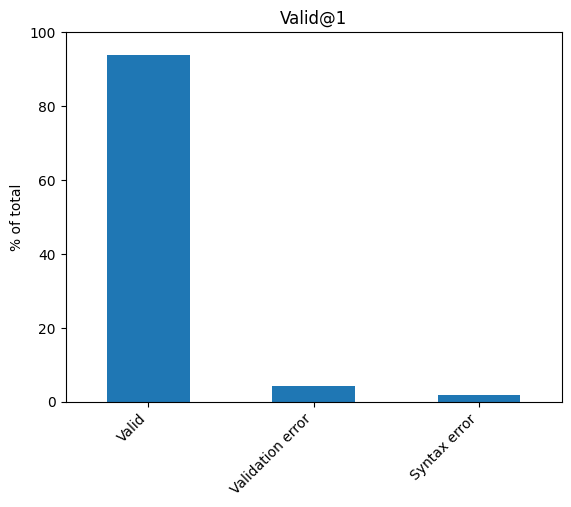

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1)
valid_in_1.plot.bar(ax=axes)
axes.set_ylim([0, 100])
axes.set_ylabel('% of total')
axes.set_xticklabels(labels=valid_in_1.index, rotation=45, ha='right')
axes.set_title('Valid@1');

## Valid@k

In [ ]:
_, valid_in_k = validation_summary(model_output['Validated spec'])
print(valid_in_k)

Valid@1    93.75
Valid@k    96.25
dtype: float64


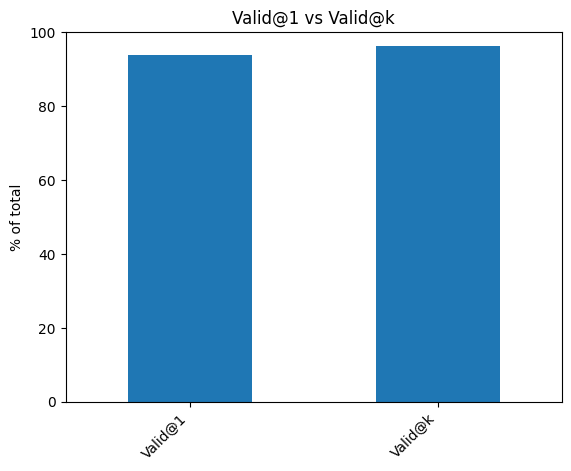

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1)
valid_in_k.plot.bar(ax=axes)
axes.set_ylim([0, 100])
axes.set_ylabel('% of total')
axes.set_xticklabels(labels=valid_in_k.index, rotation=45, ha='right')
axes.set_title('Valid@1 vs Valid@k');

## Render visualistions

In [ ]:
is_valid = pd.DataFrame(model_output['Validated spec'])
is_valid = is_valid.applymap(lambda x: 'Valid' if isinstance(x, dict) else x)
is_valid = is_valid=='Valid'
is_valid = pd.Series(is_valid.to_numpy().flatten())

validated_specs = pd.DataFrame(model_output['Validated spec'])
validated_specs = pd.Series(validated_specs.to_numpy().flatten())
validated_specs = validated_specs[is_valid]

prompts = pd.concat([input_prompts['query'] for col in range(10)], axis=1)
prompts.columns = list(range(10))
prompts = pd.Series(prompts.to_numpy().flatten())

random.seed(5)
samples = random.sample(validated_specs.index.tolist(), 5)
for index in samples:
  print(prompts[index])
  chart = alt.Chart(**validated_specs[index])
  chart.display()

plot displacement by mpg', 'color by origin


alt.Chart(...)

Show me the average profit by state


alt.Chart(...)

Sum(Sales) X Sum(Profit) Y by region render cluster


alt.Chart(...)

Stacked columns of Sum (profit) segmented by Ship Status vs Region


alt.Chart(...)

What is our profit based on shipping mode by customer segment?


alt.Chart(...)

# Save data

In [ ]:
save_object(FILE_DIRECTORY + OUTPUT_FILENAME, model_output)